In [2]:
%load_ext autoreload
%autoreload 1

In [3]:
%aimport src.utils.training_funcs
%aimport src.models.vae
%aimport src.models.pvae
%aimport src.models.encoder
%aimport src.models.decoder

In [4]:
import torch
import torch.optim as optim

import pandas as pd
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import NeighborhoodComponentsAnalysis

from torch.utils.data import DataLoader
from torchvision import transforms
from torchinfo import summary

from src.datasets import IrmaDataset
from transforms import MinMaxScaler
from src.models import VAE, PVAE
from src.utils.model_utils import train_val_split, get_latent
from src.utils.visualization import (
    plot_reconstructions,
    plot_2d,
    sample_images,
    plot_history,
)
from src.utils.training_funcs import (
    train,
    validate,
    pred_kl_reconstruction_loss,
    kl_reconstruction_loss,
    get_metrics_str,
)

In [8]:
torch.backends.cudnn.benchmark = True

In [9]:
batch_size = 32

dataset = IrmaDataset(transform=transforms.Compose([transforms.ToTensor(),
                                                    MinMaxScaler()
                                                    #   transforms.Grayscale(num_output_channels=1),
                                                    #   transforms.Normalize((0.5,), (0.5,))
                                                    ]))

datasets = train_val_split(dataset, 0.1)
datasets['test'] = datasets['val']
datasets = {**datasets, **train_val_split(datasets['train'], 0.1/0.9)}

dataloaders = {x:DataLoader(datasets[x], batch_size, shuffle=True) for x in ['train','test','val']}

len(datasets['train']), len(datasets['test']), len(datasets['val'])

(4018, 503, 503)

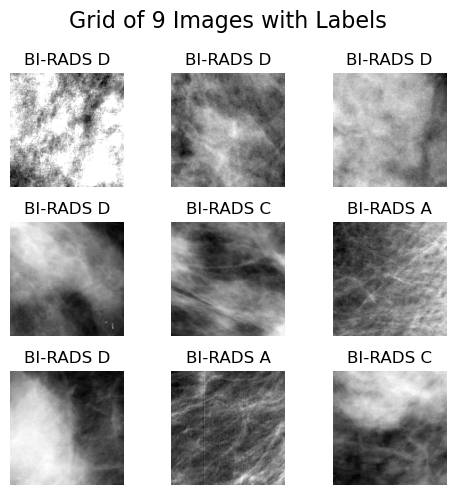

In [10]:

sample_images(dataloaders['train'], label_mapper=IrmaDataset.get_class_label)

# Arquiteturas

## VAE

### Lucca

In [34]:
kwargs, state = torch.load("models/ae_lucca.pt")

ae_lucca = VAE(**kwargs)
ae_lucca.load_state_dict(state)

summary(ae_lucca, input_size=(32, 1, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [32, 1, 128, 128]         --
├─Encoder: 1-1                           [32, 32]                  --
│    └─Sequential: 2-1                   [32, 96, 30, 30]          --
│    │    └─Conv2d: 3-1                  [32, 128, 124, 124]       3,328
│    │    └─GELU: 3-2                    [32, 128, 124, 124]       --
│    │    └─MaxPool2d: 3-3               [32, 128, 62, 62]         --
│    │    └─Conv2d: 3-4                  [32, 96, 60, 60]          110,688
│    │    └─GELU: 3-5                    [32, 96, 60, 60]          --
│    │    └─MaxPool2d: 3-6               [32, 96, 30, 30]          --
│    └─Flatten: 2-2                      [32, 86400]               --
│    └─Sequential: 2-3                   [32, 64]                  --
│    │    └─Linear: 3-7                  [32, 768]                 66,355,968
│    │    └─GELU: 3-8                    [32, 768]                 --

In [11]:
ae_lucca = VAE(
    latent_dim=32,
    conv_layers=[(5, 128), (3, 96)],
    conv_pooling=[2, 2],
    linear_input=(96, 30, 30),
    linear_layers=[768, 384, 128, 64],
)
summary(ae_lucca, input_size=(32, 1, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [32, 1, 128, 128]         --
├─Encoder: 1-1                           [32, 32]                  --
│    └─Sequential: 2-1                   [32, 96, 30, 30]          --
│    │    └─Conv2d: 3-1                  [32, 128, 124, 124]       3,328
│    │    └─GELU: 3-2                    [32, 128, 124, 124]       --
│    │    └─MaxPool2d: 3-3               [32, 128, 62, 62]         --
│    │    └─Conv2d: 3-4                  [32, 96, 60, 60]          110,688
│    │    └─GELU: 3-5                    [32, 96, 60, 60]          --
│    │    └─MaxPool2d: 3-6               [32, 96, 30, 30]          --
│    └─Flatten: 2-2                      [32, 86400]               --
│    └─Sequential: 2-3                   [32, 64]                  --
│    │    └─Linear: 3-7                  [32, 768]                 66,355,968
│    │    └─GELU: 3-8                    [32, 768]                 --

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(ae_lucca.parameters())
ae_lucca.to(device)

hist = train(ae_lucca, optimizer, dataloaders['train'], dataloaders['val'], 8, kl_reconstruction_loss)
# hist = train(ae, optimizer, dataloader, dataloader, 20)

[epoch: 1] train_loss: 39.4076 train_rec_loss: 39.2944 train_kl_loss: 0.1132 - val_loss: 18.4390 val_rec_loss: 18.3283 val_kl_loss: 0.1107


KeyboardInterrupt: 

test_loss: 4.7789 test_rec_loss: 4.6724 test_kl_loss: 0.1065


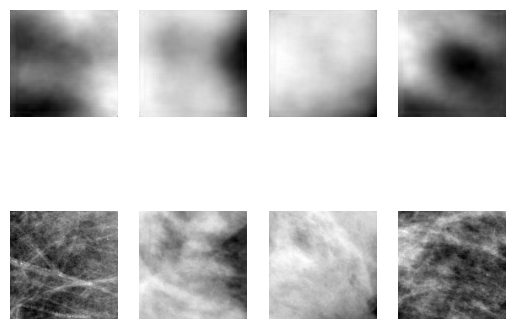

In [20]:
test_metrics = validate(ae_lucca, dataloaders['test'], kl_reconstruction_loss)

print(get_metrics_str(test_metrics, 'test_'))

plot_reconstructions(ae_lucca, dataloaders['test'])

In [10]:
torch.save((ae_lucca.kwargs ,ae_lucca.state_dict()), "models/ae_lucca.pt")

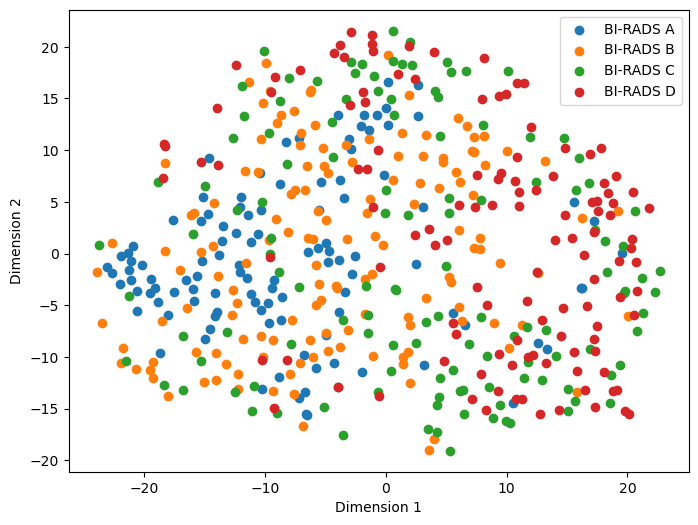

In [35]:
latent, labels = get_latent(ae_lucca, dataloaders["test"], IrmaDataset.get_class_label)

tsne = TSNE()
tsne_latent = tsne.fit_transform(latent)

plot_2d(tsne_latent, labels, 'tab10')

### 32 Dimensões

In [13]:
ae_leo = VAE(
    latent_dim=32,
    conv_layers=[(5, 64), (3, 128), (3, 256)],
    conv_pooling=[2, 2, 2],
    linear_input=(256, 14, 14),
    linear_layers=[512, 256, 128, 64],
)
summary(ae_leo, input_size=(32, 1, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [32, 1, 128, 128]         --
├─Encoder: 1-1                           [32, 32]                  --
│    └─Sequential: 2-1                   [32, 256, 14, 14]         --
│    │    └─Conv2d: 3-1                  [32, 64, 124, 124]        1,664
│    │    └─GELU: 3-2                    [32, 64, 124, 124]        --
│    │    └─MaxPool2d: 3-3               [32, 64, 62, 62]          --
│    │    └─Conv2d: 3-4                  [32, 128, 60, 60]         73,856
│    │    └─GELU: 3-5                    [32, 128, 60, 60]         --
│    │    └─MaxPool2d: 3-6               [32, 128, 30, 30]         --
│    │    └─Conv2d: 3-7                  [32, 256, 28, 28]         295,168
│    │    └─GELU: 3-8                    [32, 256, 28, 28]         --
│    │    └─MaxPool2d: 3-9               [32, 256, 14, 14]         --
│    └─Flatten: 2-2                      [32, 50176]               --
│  

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(ae_leo.parameters())
ae_leo.to(device)

hist = train(ae_leo, optimizer, dataloaders['train'], dataloaders['val'], 8, kl_reconstruction_loss)
# hist = train(ae, optimizer, dataloader, dataloader, 20)

[epoch: 1] train_loss: 29.9908 train_rec_loss: 29.9854 train_kl_loss: 0.0053 - val_loss: 26.2374 val_rec_loss: 26.2305 val_kl_loss: 0.0069
[epoch: 2] train_loss: 18.2290 train_rec_loss: 18.1506 train_kl_loss: 0.0784 - val_loss: 14.9443 val_rec_loss: 14.8597 val_kl_loss: 0.0845
[epoch: 3] train_loss: 11.3868 train_rec_loss: 11.3018 train_kl_loss: 0.0850 - val_loss: 10.3451 val_rec_loss: 10.2410 val_kl_loss: 0.1040
[epoch: 4] train_loss: 8.4608 train_rec_loss: 8.3569 train_kl_loss: 0.1039 - val_loss: 8.0905 val_rec_loss: 7.9857 val_kl_loss: 0.1048
[epoch: 5] train_loss: 8.1448 train_rec_loss: 8.0522 train_kl_loss: 0.0926 - val_loss: 8.0368 val_rec_loss: 7.9471 val_kl_loss: 0.0897
[epoch: 6] train_loss: 7.8672 train_rec_loss: 7.7765 train_kl_loss: 0.0906 - val_loss: 7.3368 val_rec_loss: 7.2397 val_kl_loss: 0.0971
[epoch: 7] train_loss: 7.3331 train_rec_loss: 7.2430 train_kl_loss: 0.0902 - val_loss: 7.2965 val_rec_loss: 7.2062 val_kl_loss: 0.0903
[epoch: 8] train_loss: 6.9816 train_rec_los

In [34]:
d = pd.DataFrame(map(lambda h: h[0], hist))

In [38]:
for i in d.columns:
    print (i)
    print(d[i])

loss
0    29.990754
1    18.228968
2    11.386813
3     8.460757
4     8.144834
5     7.867176
6     7.333146
7     6.981622
Name: loss, dtype: float64
rec_loss
0    29.985432
1    18.150593
2    11.301765
3     8.356890
4     8.052195
5     7.776545
6     7.242977
7     6.891404
Name: rec_loss, dtype: float64
kl_loss
0    0.005323
1    0.078376
2    0.085048
3    0.103867
4    0.092638
5    0.090632
6    0.090168
7    0.090218
Name: kl_loss, dtype: float64


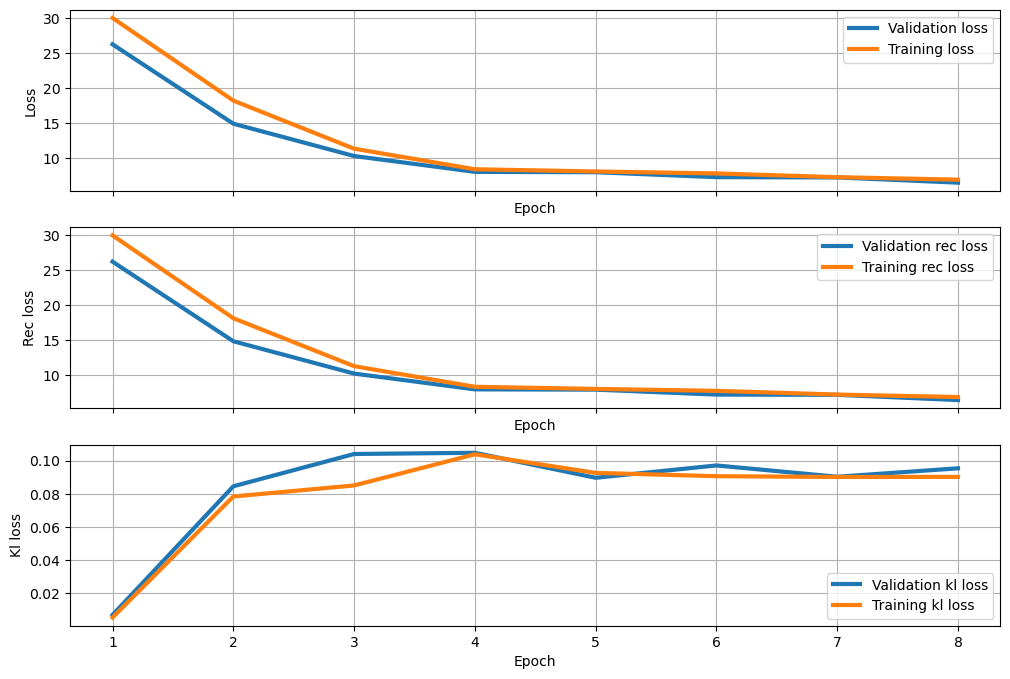

In [42]:

        
plot_results(hist)

In [50]:
torch.save((ae_leo.kwargs ,ae_leo.state_dict()), "models/ae_leo.pt")

test_loss: 6.0731 test_rec_loss: 5.9663 test_kl_loss: 0.1068


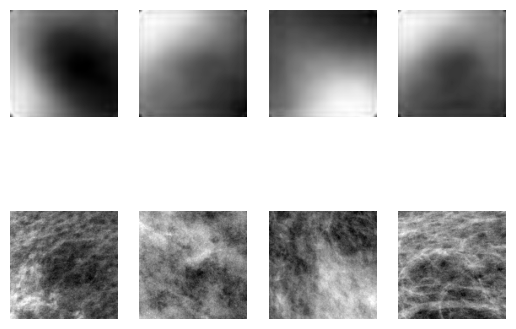

In [46]:
test_metrics = validate(ae_leo, dataloaders['test'], kl_reconstruction_loss)

print(get_metrics_str(test_metrics, 'test_'))

plot_reconstructions(ae_leo, dataloaders['test'])

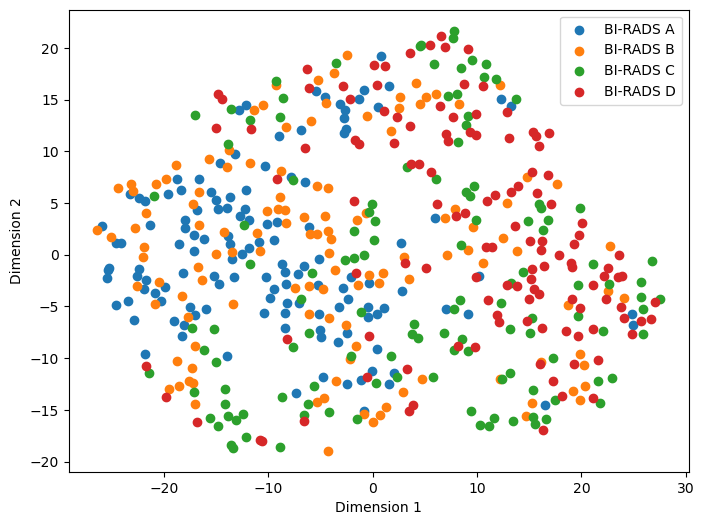

In [52]:
latent, labels = get_latent(ae_leo, dataloaders["test"], IrmaDataset.get_class_label)

tsne = TSNE()
tsne_latent = tsne.fit_transform(latent)

plot_2d(tsne_latent, labels, 'tab10')

### 64 dims

In [13]:
kwargs, state = torch.load("models/ae_leo_64.pt")

ae_leo_latent_dim64 = VAE(**kwargs)
ae_leo_latent_dim64.load_state_dict(state)

summary(ae_leo_latent_dim64, input_size=(32, 1, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [32, 1, 128, 128]         --
├─Encoder: 1-1                           [32, 64]                  --
│    └─Sequential: 2-1                   [32, 64, 6, 6]            --
│    │    └─Conv2d: 3-1                  [32, 256, 124, 124]       6,656
│    │    └─GELU: 3-2                    [32, 256, 124, 124]       --
│    │    └─MaxPool2d: 3-3               [32, 256, 62, 62]         --
│    │    └─Conv2d: 3-4                  [32, 192, 60, 60]         442,560
│    │    └─GELU: 3-5                    [32, 192, 60, 60]         --
│    │    └─MaxPool2d: 3-6               [32, 192, 30, 30]         --
│    │    └─Conv2d: 3-7                  [32, 128, 28, 28]         221,312
│    │    └─GELU: 3-8                    [32, 128, 28, 28]         --
│    │    └─MaxPool2d: 3-9               [32, 128, 14, 14]         --
│    │    └─Conv2d: 3-10                 [32, 64, 12, 12]          73,79

In [10]:
ae_leo_latent_dim64 = VAE(
    latent_dim=64,
    conv_layers=[(5, 256), (3, 192), (3, 128), (3, 64)],
    conv_pooling=[2, 2, 2, 2],
    linear_input=(64, 6, 6),
    linear_layers=[256, 128, 64],
)
summary(ae_leo_latent_dim64, input_size=(32, 1, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [32, 1, 128, 128]         --
├─Encoder: 1-1                           [32, 64]                  --
│    └─Sequential: 2-1                   [32, 64, 6, 6]            --
│    │    └─Conv2d: 3-1                  [32, 256, 124, 124]       6,656
│    │    └─GELU: 3-2                    [32, 256, 124, 124]       --
│    │    └─MaxPool2d: 3-3               [32, 256, 62, 62]         --
│    │    └─Conv2d: 3-4                  [32, 192, 60, 60]         442,560
│    │    └─GELU: 3-5                    [32, 192, 60, 60]         --
│    │    └─MaxPool2d: 3-6               [32, 192, 30, 30]         --
│    │    └─Conv2d: 3-7                  [32, 128, 28, 28]         221,312
│    │    └─GELU: 3-8                    [32, 128, 28, 28]         --
│    │    └─MaxPool2d: 3-9               [32, 128, 14, 14]         --
│    │    └─Conv2d: 3-10                 [32, 64, 12, 12]          73,79

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(ae_leo_latent_dim64.parameters())
ae_leo_latent_dim64.to(device)

hist = train(ae_leo_latent_dim64, optimizer, dataloaders['train'], dataloaders['val'], 32, kl_reconstruction_loss)
# hist = train(ae, optimizer, dataloader, dataloader, 20)

[epoch: 1] train_loss: 24.8747 train_rec_loss: 24.8293 train_kl_loss: 0.0455 - val_loss: 11.4968 val_rec_loss: 11.3910 val_kl_loss: 0.1057
[epoch: 2] train_loss: 9.8255 train_rec_loss: 9.7267 train_kl_loss: 0.0987 - val_loss: 8.8673 val_rec_loss: 8.7821 val_kl_loss: 0.0852
[epoch: 3] train_loss: 8.0303 train_rec_loss: 7.9357 train_kl_loss: 0.0946 - val_loss: 7.2551 val_rec_loss: 7.1679 val_kl_loss: 0.0872
[epoch: 4] train_loss: 6.8296 train_rec_loss: 6.7360 train_kl_loss: 0.0937 - val_loss: 6.4768 val_rec_loss: 6.3780 val_kl_loss: 0.0988
[epoch: 5] train_loss: 6.3387 train_rec_loss: 6.2489 train_kl_loss: 0.0898 - val_loss: 6.2212 val_rec_loss: 6.1346 val_kl_loss: 0.0866
[epoch: 6] train_loss: 6.0260 train_rec_loss: 5.9368 train_kl_loss: 0.0892 - val_loss: 5.9389 val_rec_loss: 5.8476 val_kl_loss: 0.0913
[epoch: 7] train_loss: 5.7096 train_rec_loss: 5.6219 train_kl_loss: 0.0877 - val_loss: 5.6370 val_rec_loss: 5.5544 val_kl_loss: 0.0826
[epoch: 8] train_loss: 5.5175 train_rec_loss: 5.430

In [12]:
torch.save((ae_leo_latent_dim64.kwargs ,ae_leo_latent_dim64.state_dict()), "models/ae_leo_64.pt")

test_loss: 4.2072 test_rec_loss: 4.1181 test_kl_loss: 0.0891


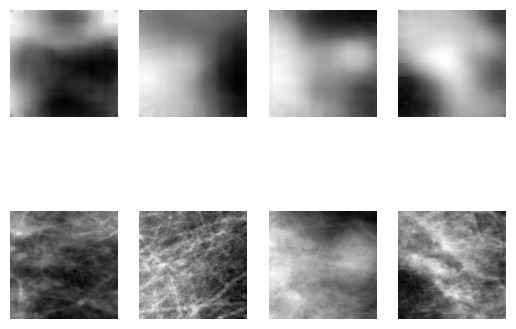

In [13]:
test_metrics = validate(ae_leo_latent_dim64, dataloaders['test'], kl_reconstruction_loss)

print(get_metrics_str(test_metrics, 'test_'))

plot_reconstructions(ae_leo_latent_dim64, dataloaders['test'])

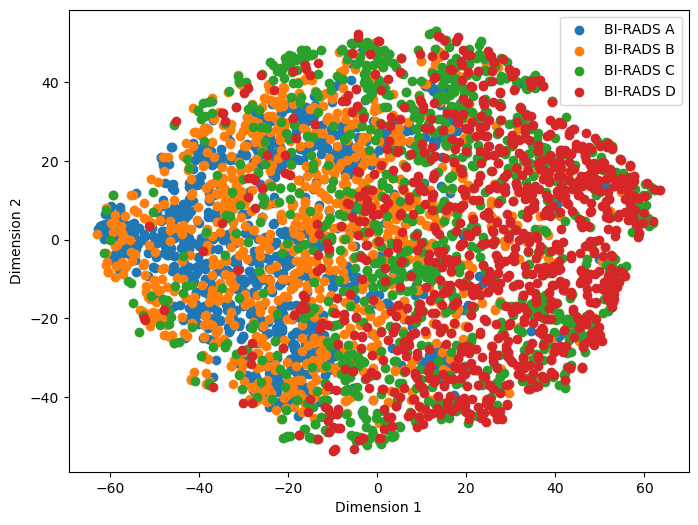

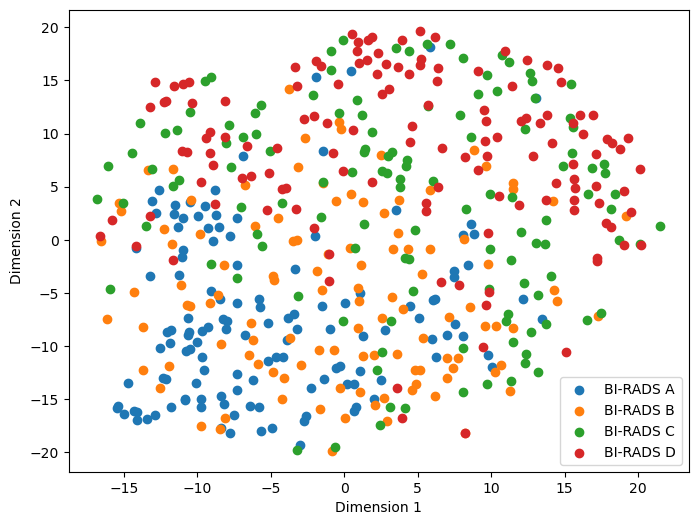

In [14]:
train_latent, train_labels = get_latent(ae_leo_latent_dim64, dataloaders["train"], IrmaDataset.get_class_label)
latent, labels = get_latent(ae_leo_latent_dim64, dataloaders["test"], IrmaDataset.get_class_label)

tsne = TSNE()
train_tsne_latent = tsne.fit_transform(train_latent, train_labels)
tsne_latent = tsne.fit_transform(latent)

plot_2d(train_tsne_latent, train_labels, 'tab10')
plot_2d(tsne_latent, labels, 'tab10')

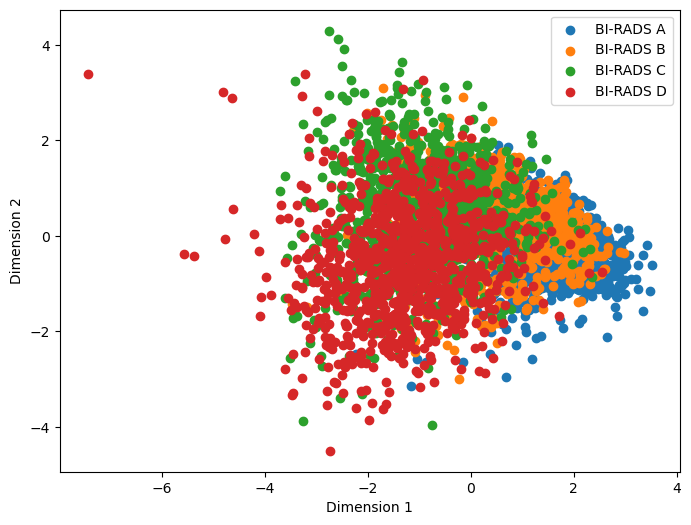

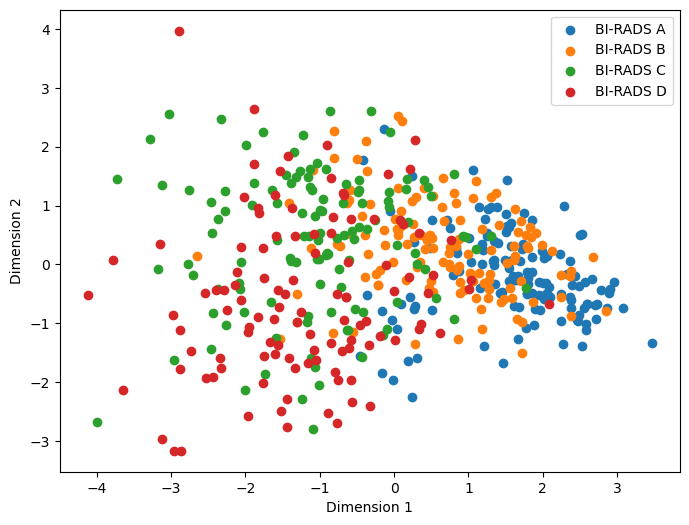

In [34]:
train_latent, train_labels = get_latent(ae_leo_latent_dim64, dataloaders["train"], IrmaDataset.get_class_label)
latent, labels = get_latent(ae_leo_latent_dim64, dataloaders["test"], IrmaDataset.get_class_label)

LDA = LinearDiscriminantAnalysis(n_components=2)
train_LDA_latent = LDA.fit_transform(train_latent, train_labels)
LDA_latent = LDA.transform(latent)

plot_2d(train_LDA_latent, train_labels, 'tab10')
plot_2d(LDA_latent, labels, 'tab10')

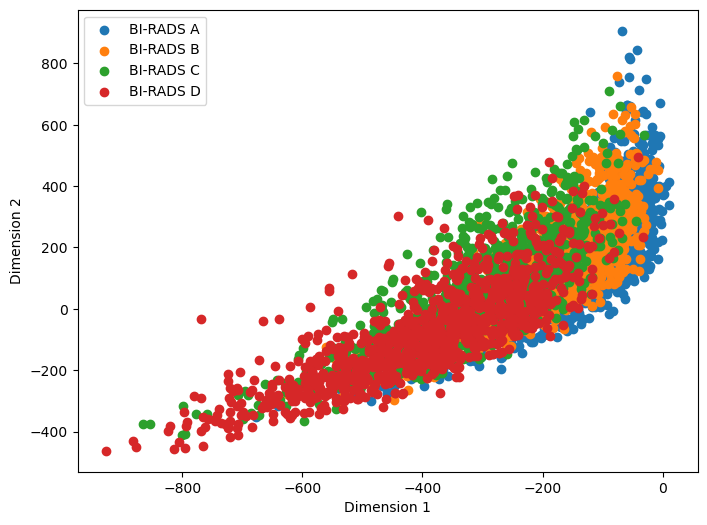

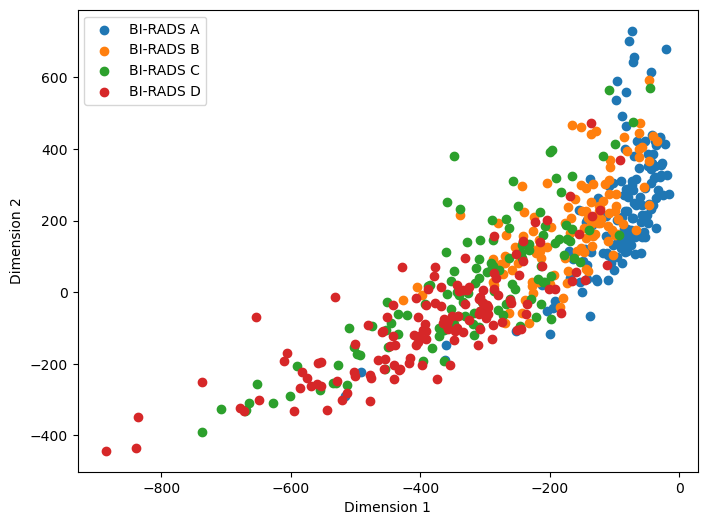

In [15]:
train_latent, train_labels = get_latent(ae_leo_latent_dim64, dataloaders["train"], IrmaDataset.get_class_label)
latent, labels = get_latent(ae_leo_latent_dim64, dataloaders["test"], IrmaDataset.get_class_label)

NCA = NeighborhoodComponentsAnalysis(n_components=2)
train_NCA_latent = NCA.fit_transform(train_latent, train_labels)
NCA_latent = NCA.transform(latent)

plot_2d(train_NCA_latent, train_labels, 'tab10')
plot_2d(NCA_latent, labels, 'tab10')

### 128 dims (pequeno)

In [18]:
ae_leo_128 = VAE(
    latent_dim=128,
    conv_layers=[(5, 64), (3, 128), (3, 256)],
    conv_pooling=[2, 2, 2],
    linear_input=(256, 14, 14),
    linear_layers=[512, 256, 128, 64],
)
summary(ae_leo_128, input_size=(32, 1, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [32, 1, 128, 128]         --
├─Encoder: 1-1                           [32, 128]                 --
│    └─Sequential: 2-1                   [32, 256, 14, 14]         --
│    │    └─Conv2d: 3-1                  [32, 64, 124, 124]        1,664
│    │    └─GELU: 3-2                    [32, 64, 124, 124]        --
│    │    └─MaxPool2d: 3-3               [32, 64, 62, 62]          --
│    │    └─Conv2d: 3-4                  [32, 128, 60, 60]         73,856
│    │    └─GELU: 3-5                    [32, 128, 60, 60]         --
│    │    └─MaxPool2d: 3-6               [32, 128, 30, 30]         --
│    │    └─Conv2d: 3-7                  [32, 256, 28, 28]         295,168
│    │    └─GELU: 3-8                    [32, 256, 28, 28]         --
│    │    └─MaxPool2d: 3-9               [32, 256, 14, 14]         --
│    └─Flatten: 2-2                      [32, 50176]               --
│  

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(ae_leo_128.parameters())
ae_leo_128.to(device)

hist = train(ae_leo_128, optimizer, dataloaders['train'], dataloaders['val'], 32, kl_reconstruction_loss)
# hist = train(ae, optimizer, dataloader, dataloader, 20)

[epoch: 1] train_loss: 33.5552 train_rec_loss: 33.5428 train_kl_loss: 0.0123 - val_loss: 22.0035 val_rec_loss: 21.9977 val_kl_loss: 0.0058
[epoch: 2] train_loss: 17.0515 train_rec_loss: 17.0219 train_kl_loss: 0.0296 - val_loss: 13.5179 val_rec_loss: 13.4703 val_kl_loss: 0.0476
[epoch: 3] train_loss: 11.6829 train_rec_loss: 11.6290 train_kl_loss: 0.0539 - val_loss: 11.0988 val_rec_loss: 11.0395 val_kl_loss: 0.0594
[epoch: 4] train_loss: 9.3532 train_rec_loss: 9.2748 train_kl_loss: 0.0784 - val_loss: 9.1713 val_rec_loss: 9.0904 val_kl_loss: 0.0809
[epoch: 5] train_loss: 8.3701 train_rec_loss: 8.2918 train_kl_loss: 0.0783 - val_loss: 8.3816 val_rec_loss: 8.3081 val_kl_loss: 0.0735
[epoch: 6] train_loss: 80.7878 train_rec_loss: 80.7363 train_kl_loss: 0.0515 - val_loss: 57.5007 val_rec_loss: 57.4885 val_kl_loss: 0.0122
[epoch: 7] train_loss: 23.3319 train_rec_loss: 23.1843 train_kl_loss: 0.1476 - val_loss: 14.0155 val_rec_loss: 13.8275 val_kl_loss: 0.1879
[epoch: 8] train_loss: 12.9831 trai

In [20]:
torch.save((ae_leo_128.kwargs, ae_leo_128.state_dict()), "models/ae_leo_128.pt")

test_loss: 6.4110 test_rec_loss: 6.2880 test_kl_loss: 0.1230


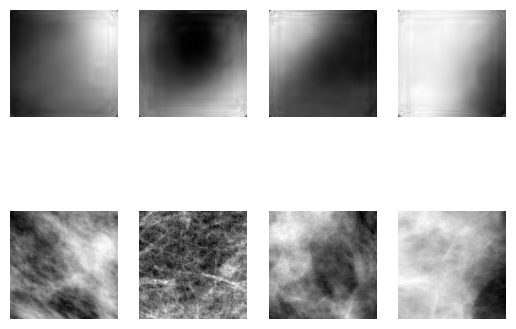

In [ ]:
test_metrics = validate(ae_leo_128, dataloaders['test'], kl_reconstruction_loss)

print(get_metrics_str(test_metrics, 'test_'))

plot_reconstructions(ae_leo_128, dataloaders['test'])

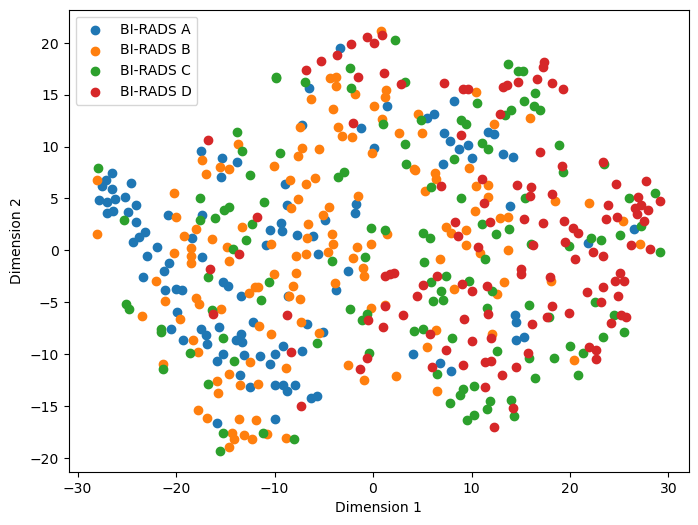

In [22]:
latent, labels = get_latent(ae_leo_128, dataloaders["test"], IrmaDataset.get_class_label)

tsne = TSNE()
tsne_latent = tsne.fit_transform(latent)

plot_2d(tsne_latent, labels, 'tab10')

### 128 dims (grande)

In [28]:
ae_leo_128_big = VAE(
    latent_dim=128,
    conv_layers=[(5, 192), (3, 128), (3, 96), (3, 64)],
    conv_pooling=[2, 2, 2, 2],
    linear_input=(64, 6, 6),
    linear_layers=[256, 128, 64],
)
summary(ae_leo_128_big, input_size=(32, 1, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [32, 1, 128, 128]         --
├─Encoder: 1-1                           [32, 128]                 --
│    └─Sequential: 2-1                   [32, 64, 6, 6]            --
│    │    └─Conv2d: 3-1                  [32, 192, 124, 124]       4,992
│    │    └─GELU: 3-2                    [32, 192, 124, 124]       --
│    │    └─MaxPool2d: 3-3               [32, 192, 62, 62]         --
│    │    └─Conv2d: 3-4                  [32, 128, 60, 60]         221,312
│    │    └─GELU: 3-5                    [32, 128, 60, 60]         --
│    │    └─MaxPool2d: 3-6               [32, 128, 30, 30]         --
│    │    └─Conv2d: 3-7                  [32, 96, 28, 28]          110,688
│    │    └─GELU: 3-8                    [32, 96, 28, 28]          --
│    │    └─MaxPool2d: 3-9               [32, 96, 14, 14]          --
│    │    └─Conv2d: 3-10                 [32, 64, 12, 12]          55,36

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(ae_leo_128_big.parameters())
ae_leo_128_big.to(device)

hist = train(ae_leo_128_big, optimizer, dataloaders['train'], dataloaders['val'], 24, kl_reconstruction_loss)
# hist = train(ae, optimizer, dataloader, dataloader, 20)

[epoch: 1] train_loss: 25.0981 train_rec_loss: 25.0812 train_kl_loss: 0.0169 - val_loss: 15.8291 val_rec_loss: 15.7885 val_kl_loss: 0.0406
[epoch: 2] train_loss: 11.4011 train_rec_loss: 11.3225 train_kl_loss: 0.0786 - val_loss: 9.2679 val_rec_loss: 9.1699 val_kl_loss: 0.0980
[epoch: 3] train_loss: 8.7658 train_rec_loss: 8.6877 train_kl_loss: 0.0781 - val_loss: 8.6765 val_rec_loss: 8.6113 val_kl_loss: 0.0652
[epoch: 4] train_loss: 8.5111 train_rec_loss: 8.4422 train_kl_loss: 0.0689 - val_loss: 8.0365 val_rec_loss: 7.9565 val_kl_loss: 0.0800
[epoch: 5] train_loss: 7.3103 train_rec_loss: 7.2293 train_kl_loss: 0.0810 - val_loss: 7.1445 val_rec_loss: 7.0656 val_kl_loss: 0.0789
[epoch: 6] train_loss: 6.4587 train_rec_loss: 6.3797 train_kl_loss: 0.0790 - val_loss: 6.2745 val_rec_loss: 6.1998 val_kl_loss: 0.0747
[epoch: 7] train_loss: 6.1948 train_rec_loss: 6.1169 train_kl_loss: 0.0779 - val_loss: 6.0763 val_rec_loss: 5.9937 val_kl_loss: 0.0827
[epoch: 8] train_loss: 5.9894 train_rec_loss: 5.9

In [30]:
torch.save((ae_leo_128_big.kwargs, ae_leo_128_big.state_dict()), "models/ae_leo_128_big.pt")

test_loss: 4.5230 test_rec_loss: 4.4412 test_kl_loss: 0.0817


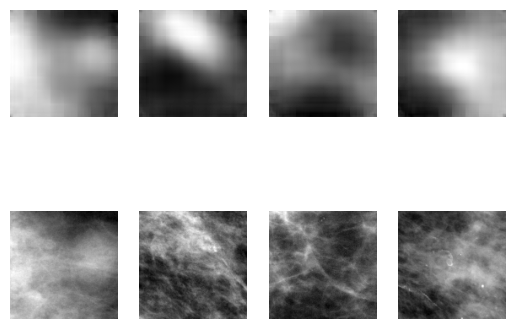

In [31]:
test_metrics = validate(ae_leo_128_big, dataloaders['test'], kl_reconstruction_loss)

print(get_metrics_str(test_metrics, 'test_'))

plot_reconstructions(ae_leo_128_big, dataloaders['test'])

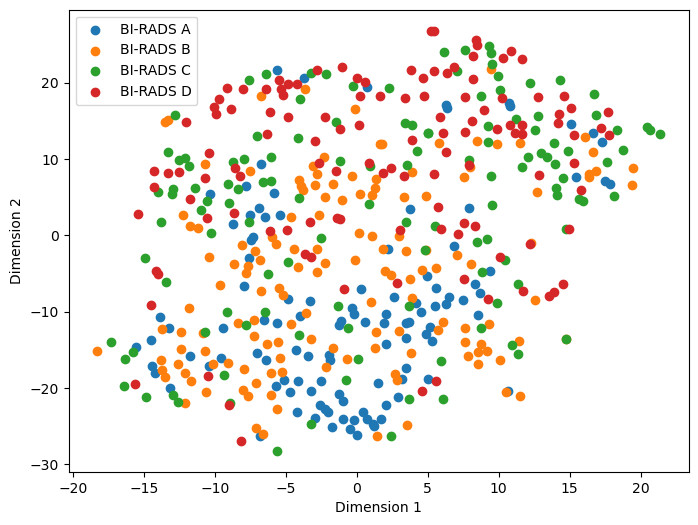

In [32]:
latent, labels = get_latent(ae_leo_128_big, dataloaders["test"], IrmaDataset.get_class_label)

tsne = TSNE()
tsne_latent = tsne.fit_transform(latent)

plot_2d(tsne_latent, labels, 'tab10')

## P-VAE

### 32 Dims

In [10]:
torch.cuda.empty_cache()

In [11]:
pvae_32 = PVAE(
    latent_dim=32,
    conv_layers=[(5, 128), (3, 96)],
    conv_pooling=[2, 2],
    linear_input=(96, 30, 30),
    linear_layers=[768, 384, 128, 64],
    pred_layers=[128, 64],
    n_classes=4,
)
summary(pvae_32, input_size=(32, 1, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
PVAE                                     [32, 1, 128, 128]         --
├─Encoder: 1-1                           [32, 32]                  --
│    └─Sequential: 2-1                   [32, 96, 30, 30]          --
│    │    └─Conv2d: 3-1                  [32, 128, 124, 124]       3,328
│    │    └─GELU: 3-2                    [32, 128, 124, 124]       --
│    │    └─MaxPool2d: 3-3               [32, 128, 62, 62]         --
│    │    └─Conv2d: 3-4                  [32, 96, 60, 60]          110,688
│    │    └─GELU: 3-5                    [32, 96, 60, 60]          --
│    │    └─MaxPool2d: 3-6               [32, 96, 30, 30]          --
│    └─Flatten: 2-2                      [32, 86400]               --
│    └─Sequential: 2-3                   [32, 64]                  --
│    │    └─Linear: 3-7                  [32, 768]                 66,355,968
│    │    └─GELU: 3-8                    [32, 768]                 --

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(pvae_32.parameters())
pvae_32.to(device)

hist = train(pvae_32, optimizer, dataloaders['train'], dataloaders['val'], 32, pred_kl_reconstruction_loss)

[epoch: 1] train_loss: 23.7839 train_rec_loss: 22.3493 train_kl_loss: 0.0974 train_pred_loss: 1.3372 train_accuracy: 0.3395 - val_loss: 12.3502 val_rec_loss: 10.9349 val_kl_loss: 0.1190 val_pred_loss: 1.2963 val_accuracy: 0.3956
[epoch: 2] train_loss: 10.4329 train_rec_loss: 9.0541 train_kl_loss: 0.1232 train_pred_loss: 1.2556 train_accuracy: 0.4699 - val_loss: 9.4401 val_rec_loss: 8.0997 val_kl_loss: 0.1210 val_pred_loss: 1.2194 val_accuracy: 0.5169
[epoch: 3] train_loss: 9.3461 train_rec_loss: 8.0261 train_kl_loss: 0.1040 train_pred_loss: 1.2159 train_accuracy: 0.5142 - val_loss: 9.1585 val_rec_loss: 7.8568 val_kl_loss: 0.0988 val_pred_loss: 1.2028 val_accuracy: 0.5388
[epoch: 4] train_loss: 9.0629 train_rec_loss: 7.7646 train_kl_loss: 0.0972 train_pred_loss: 1.2011 train_accuracy: 0.5316 - val_loss: 8.4096 val_rec_loss: 7.1189 val_kl_loss: 0.0990 val_pred_loss: 1.1917 val_accuracy: 0.5527
[epoch: 5] train_loss: 8.5572 train_rec_loss: 7.2854 train_kl_loss: 0.0977 train_pred_loss: 1.1

In [13]:
torch.save((pvae_32.kwargs ,pvae_32.state_dict()), "models/pvae_32.pt")

test_loss: 5.9955 test_rec_loss: 4.7693 test_kl_loss: 0.1002 test_pred_loss: 1.1261 test_accuracy: 0.6103


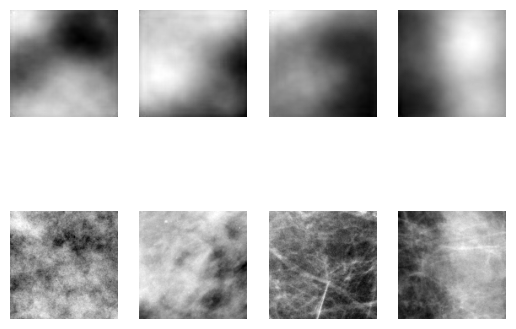

In [14]:
test_metrics = validate(pvae_32, dataloaders['test'], pred_kl_reconstruction_loss)

print(get_metrics_str(test_metrics, 'test_'))

plot_reconstructions(pvae_32, dataloaders['test'])

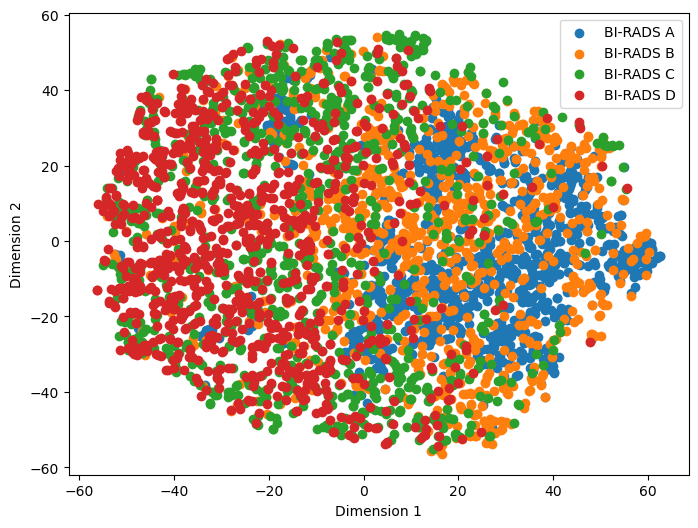

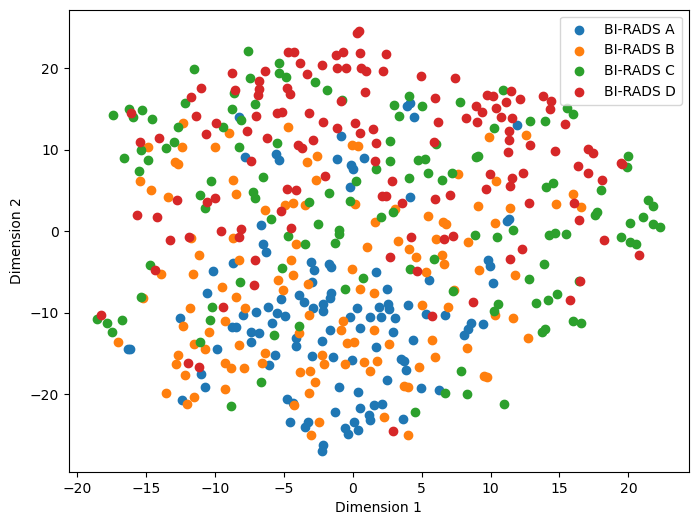

In [16]:
train_latent, train_labels = get_latent(pvae_32, dataloaders["train"], IrmaDataset.get_class_label)
latent, labels = get_latent(pvae_32, dataloaders["test"], IrmaDataset.get_class_label)

tsne = TSNE()
train_tsne_latent = tsne.fit_transform(train_latent, train_labels)
tsne_latent = tsne.fit_transform(latent)

plot_2d(train_tsne_latent, train_labels, 'tab10')
plot_2d(tsne_latent, labels, 'tab10')

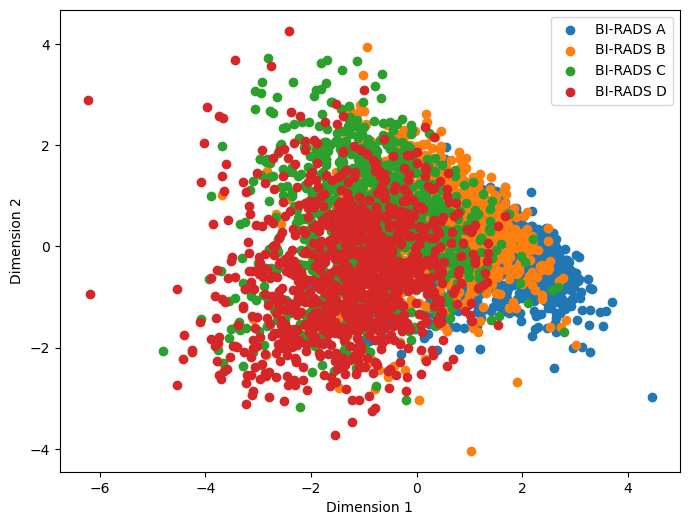

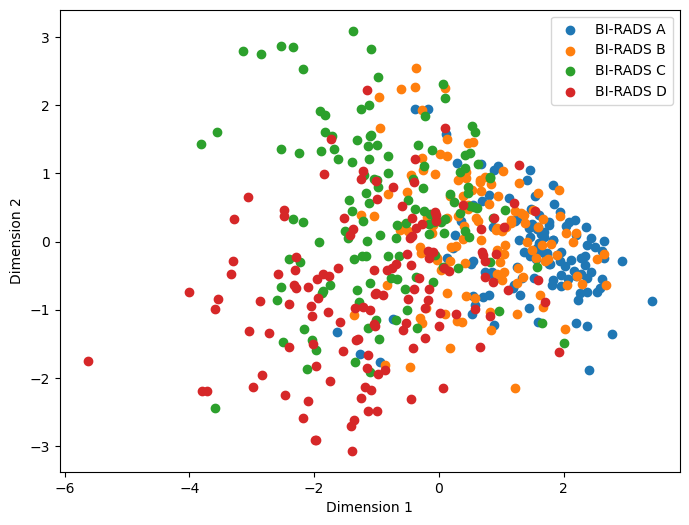

In [17]:
train_latent, train_labels = get_latent(pvae_32, dataloaders["train"], IrmaDataset.get_class_label)
latent, labels = get_latent(pvae_32, dataloaders["test"], IrmaDataset.get_class_label)

LDA = LinearDiscriminantAnalysis(n_components=2)
train_LDA_latent = LDA.fit_transform(train_latent, train_labels)
LDA_latent = LDA.transform(latent)

plot_2d(train_LDA_latent, train_labels, 'tab10')
plot_2d(LDA_latent, labels, 'tab10')

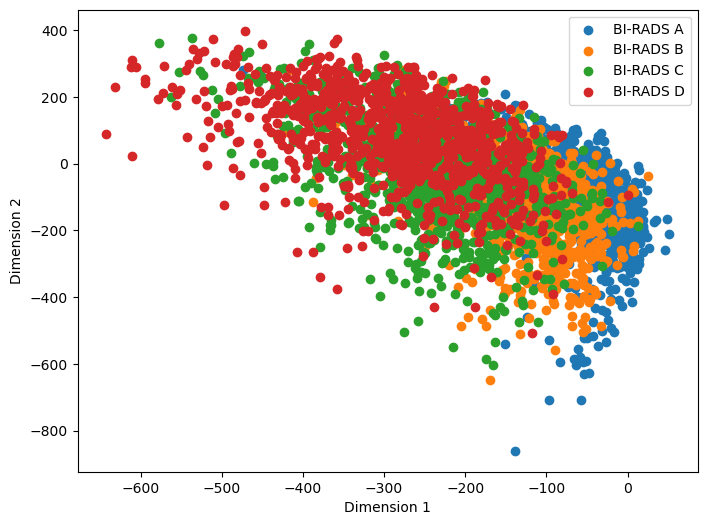

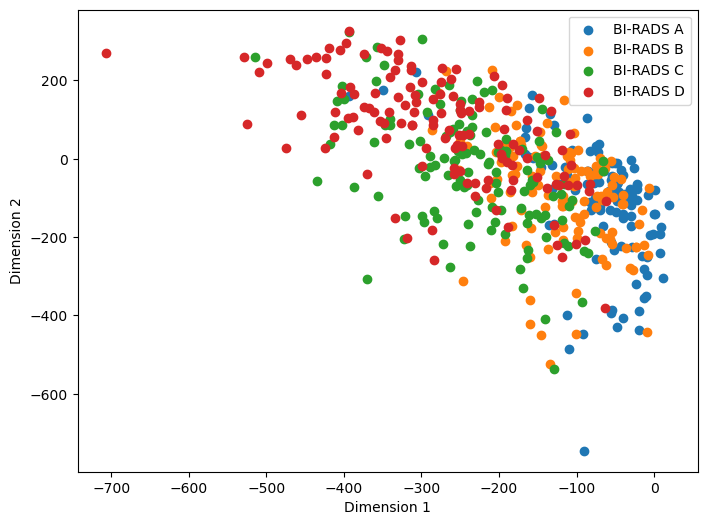

In [18]:
train_latent, train_labels = get_latent(pvae_32, dataloaders["train"], IrmaDataset.get_class_label)
latent, labels = get_latent(pvae_32, dataloaders["test"], IrmaDataset.get_class_label)

NCA = NeighborhoodComponentsAnalysis(n_components=2)
train_NCA_latent = NCA.fit_transform(train_latent, train_labels)
NCA_latent = NCA.transform(latent)

plot_2d(train_NCA_latent, train_labels, 'tab10')
plot_2d(NCA_latent, labels, 'tab10')

In [19]:
del pvae_32
torch.cuda.empty_cache()

### 32 Dims - 2

In [20]:
pvae_32_2 = PVAE(
    latent_dim=32,
    conv_layers=[(5, 192), (3, 128), (3, 96), (3, 64)],
    conv_pooling=[2, 2, 2, 2],
    linear_input=(64, 6, 6),
    linear_layers=[256, 128, 64],
    pred_layers=[128, 64],
    n_classes=4,
)
summary(pvae_32_2, input_size=(32, 1, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
PVAE                                     [32, 1, 128, 128]         --
├─Encoder: 1-1                           [32, 32]                  --
│    └─Sequential: 2-1                   [32, 64, 6, 6]            --
│    │    └─Conv2d: 3-1                  [32, 192, 124, 124]       4,992
│    │    └─GELU: 3-2                    [32, 192, 124, 124]       --
│    │    └─MaxPool2d: 3-3               [32, 192, 62, 62]         --
│    │    └─Conv2d: 3-4                  [32, 128, 60, 60]         221,312
│    │    └─GELU: 3-5                    [32, 128, 60, 60]         --
│    │    └─MaxPool2d: 3-6               [32, 128, 30, 30]         --
│    │    └─Conv2d: 3-7                  [32, 96, 28, 28]          110,688
│    │    └─GELU: 3-8                    [32, 96, 28, 28]          --
│    │    └─MaxPool2d: 3-9               [32, 96, 14, 14]          --
│    │    └─Conv2d: 3-10                 [32, 64, 12, 12]          55,36

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(pvae_32_2.parameters())
pvae_32_2.to(device)

hist = train(pvae_32_2, optimizer, dataloaders['train'], dataloaders['val'], 32, pred_kl_reconstruction_loss)

[epoch: 1] train_loss: 27.1230 train_rec_loss: 25.7691 train_kl_loss: 0.0249 train_pred_loss: 1.3291 train_accuracy: 0.3549 - val_loss: 15.9388 val_rec_loss: 14.6075 val_kl_loss: 0.0721 val_pred_loss: 1.2591 val_accuracy: 0.4453
[epoch: 2] train_loss: 12.6689 train_rec_loss: 11.3504 train_kl_loss: 0.0796 train_pred_loss: 1.2389 train_accuracy: 0.4736 - val_loss: 10.2260 val_rec_loss: 8.9250 val_kl_loss: 0.0780 val_pred_loss: 1.2230 val_accuracy: 0.4791
[epoch: 3] train_loss: 9.7140 train_rec_loss: 8.4214 train_kl_loss: 0.0871 train_pred_loss: 1.2055 train_accuracy: 0.5189 - val_loss: 9.2637 val_rec_loss: 7.9645 val_kl_loss: 0.0920 val_pred_loss: 1.2073 val_accuracy: 0.5050
[epoch: 4] train_loss: 8.8975 train_rec_loss: 7.6177 train_kl_loss: 0.0901 train_pred_loss: 1.1898 train_accuracy: 0.5411 - val_loss: 8.0660 val_rec_loss: 6.7803 val_kl_loss: 0.1026 val_pred_loss: 1.1831 val_accuracy: 0.5527
[epoch: 5] train_loss: 7.6714 train_rec_loss: 6.4193 train_kl_loss: 0.0946 train_pred_loss: 1

In [22]:
torch.save((pvae_32_2.kwargs ,pvae_32_2.state_dict()), "models/pvae_32_2.pt")

test_loss: 5.3411 test_rec_loss: 4.1509 test_kl_loss: 0.1016 test_pred_loss: 1.0887 test_accuracy: 0.6382


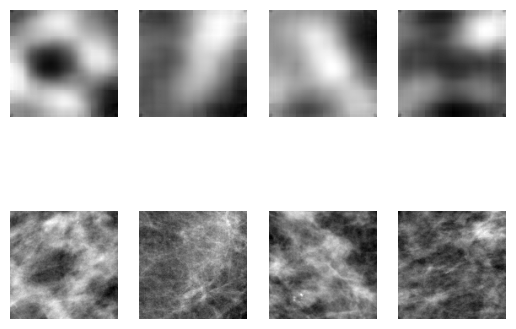

In [23]:
test_metrics = validate(pvae_32_2, dataloaders['test'], pred_kl_reconstruction_loss)

print(get_metrics_str(test_metrics, 'test_'))

plot_reconstructions(pvae_32_2, dataloaders['test'])

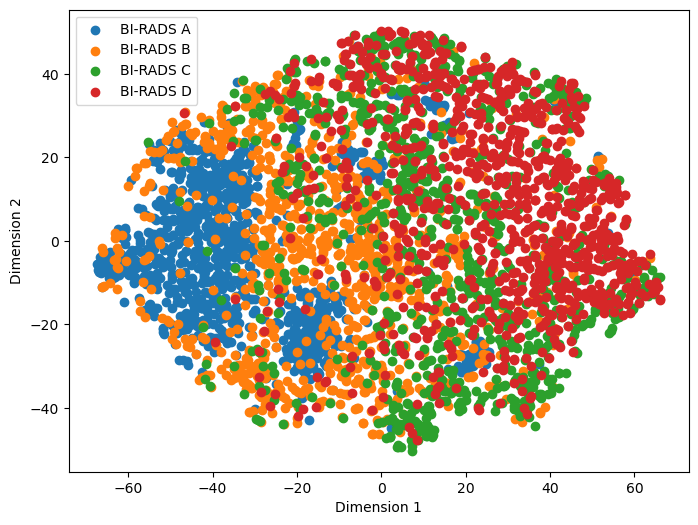

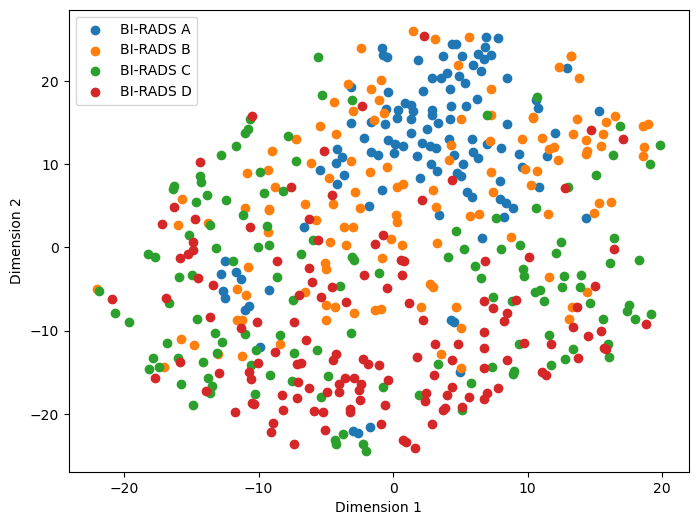

In [24]:
train_latent, train_labels = get_latent(pvae_32_2, dataloaders["train"], IrmaDataset.get_class_label)
latent, labels = get_latent(pvae_32_2, dataloaders["test"], IrmaDataset.get_class_label)

tsne = TSNE()
train_tsne_latent = tsne.fit_transform(train_latent, train_labels)
tsne_latent = tsne.fit_transform(latent)

plot_2d(train_tsne_latent, train_labels, 'tab10')
plot_2d(tsne_latent, labels, 'tab10')

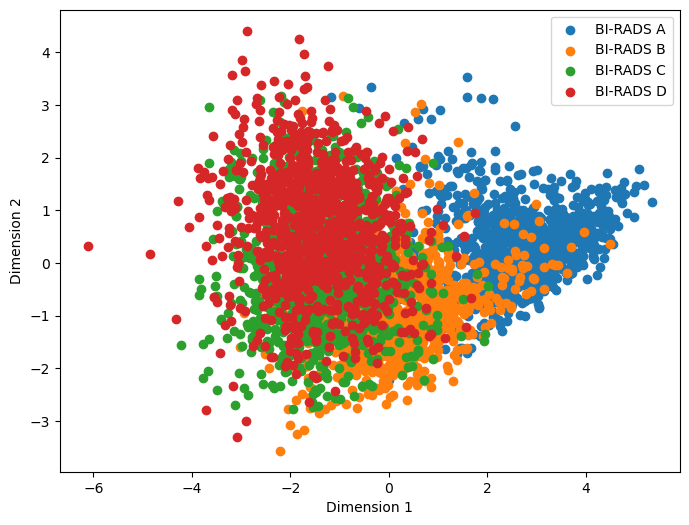

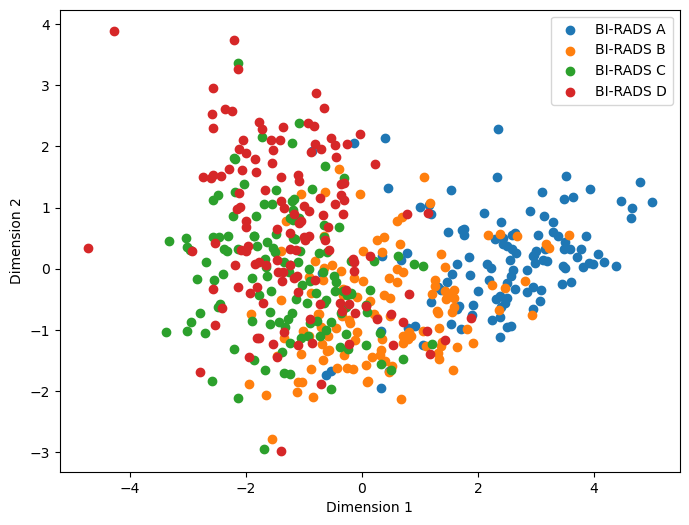

In [25]:
train_latent, train_labels = get_latent(pvae_32_2, dataloaders["train"], IrmaDataset.get_class_label)
latent, labels = get_latent(pvae_32_2, dataloaders["test"], IrmaDataset.get_class_label)

LDA = LinearDiscriminantAnalysis(n_components=2)
train_LDA_latent = LDA.fit_transform(train_latent, train_labels)
LDA_latent = LDA.transform(latent)

plot_2d(train_LDA_latent, train_labels, 'tab10')
plot_2d(LDA_latent, labels, 'tab10')

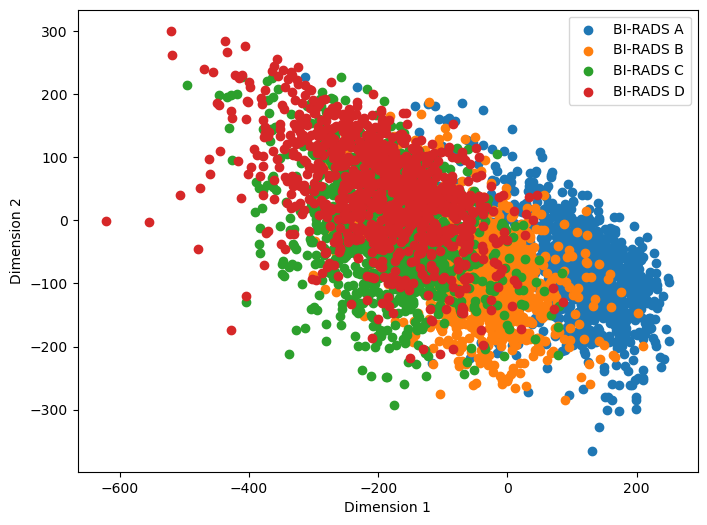

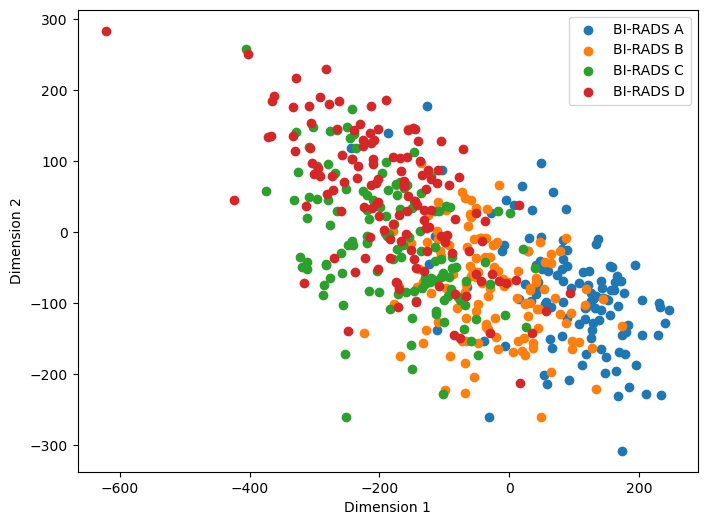

In [26]:
train_latent, train_labels = get_latent(pvae_32_2, dataloaders["train"], IrmaDataset.get_class_label)
latent, labels = get_latent(pvae_32_2, dataloaders["test"], IrmaDataset.get_class_label)

NCA = NeighborhoodComponentsAnalysis(n_components=2)
train_NCA_latent = NCA.fit_transform(train_latent, train_labels)
NCA_latent = NCA.transform(latent)

plot_2d(train_NCA_latent, train_labels, 'tab10')
plot_2d(NCA_latent, labels, 'tab10')

In [27]:
del pvae_32_2
torch.cuda.empty_cache()

### 64 dims

In [28]:
pvae_64 = PVAE(
    latent_dim=64,
    conv_layers=[(5, 192), (3, 128), (3, 96), (3, 64)],
    conv_pooling=[2, 2, 2, 2],
    linear_input=(64, 6, 6),
    linear_layers=[256, 128, 64],
    pred_layers=[128, 64],
    n_classes=4,
)
summary(pvae_64, input_size=(32, 1, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
PVAE                                     [32, 1, 128, 128]         --
├─Encoder: 1-1                           [32, 64]                  --
│    └─Sequential: 2-1                   [32, 64, 6, 6]            --
│    │    └─Conv2d: 3-1                  [32, 192, 124, 124]       4,992
│    │    └─GELU: 3-2                    [32, 192, 124, 124]       --
│    │    └─MaxPool2d: 3-3               [32, 192, 62, 62]         --
│    │    └─Conv2d: 3-4                  [32, 128, 60, 60]         221,312
│    │    └─GELU: 3-5                    [32, 128, 60, 60]         --
│    │    └─MaxPool2d: 3-6               [32, 128, 30, 30]         --
│    │    └─Conv2d: 3-7                  [32, 96, 28, 28]          110,688
│    │    └─GELU: 3-8                    [32, 96, 28, 28]          --
│    │    └─MaxPool2d: 3-9               [32, 96, 14, 14]          --
│    │    └─Conv2d: 3-10                 [32, 64, 12, 12]          55,36

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(pvae_64.parameters())
pvae_64.to(device)

hist = train(pvae_64, optimizer, dataloaders['train'], dataloaders['val'], 32, pred_kl_reconstruction_loss)
# hist = train(ae, optimizer, dataloader, dataloader, 20)

[epoch: 1] train_loss: 25.2223 train_rec_loss: 23.8391 train_kl_loss: 0.0227 train_pred_loss: 1.3605 train_accuracy: 0.3064 - val_loss: 16.4925 val_rec_loss: 15.1813 val_kl_loss: 0.0382 val_pred_loss: 1.2730 val_accuracy: 0.4473
[epoch: 2] train_loss: 13.0229 train_rec_loss: 11.7008 train_kl_loss: 0.0651 train_pred_loss: 1.2570 train_accuracy: 0.4500 - val_loss: 10.3556 val_rec_loss: 9.0356 val_kl_loss: 0.0750 val_pred_loss: 1.2450 val_accuracy: 0.4791
[epoch: 3] train_loss: 9.8662 train_rec_loss: 8.5753 train_kl_loss: 0.0722 train_pred_loss: 1.2186 train_accuracy: 0.5000 - val_loss: 9.2201 val_rec_loss: 7.9347 val_kl_loss: 0.0768 val_pred_loss: 1.2087 val_accuracy: 0.5050
[epoch: 4] train_loss: 8.9916 train_rec_loss: 7.7300 train_kl_loss: 0.0777 train_pred_loss: 1.1838 train_accuracy: 0.5475 - val_loss: 8.8789 val_rec_loss: 7.6307 val_kl_loss: 0.0787 val_pred_loss: 1.1695 val_accuracy: 0.5726
[epoch: 5] train_loss: 8.4128 train_rec_loss: 7.1738 train_kl_loss: 0.0785 train_pred_loss: 1

In [30]:
torch.save((pvae_64.kwargs ,pvae_64.state_dict()), "models/pvae_64.pt")

test_loss: 5.8182 test_rec_loss: 4.5785 test_kl_loss: 0.0920 test_pred_loss: 1.1477 test_accuracy: 0.5865


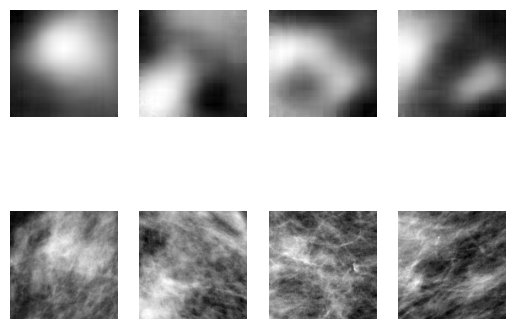

In [31]:
test_metrics = validate(pvae_64, dataloaders['test'], pred_kl_reconstruction_loss)

print(get_metrics_str(test_metrics, 'test_'))

plot_reconstructions(pvae_64, dataloaders['test'])

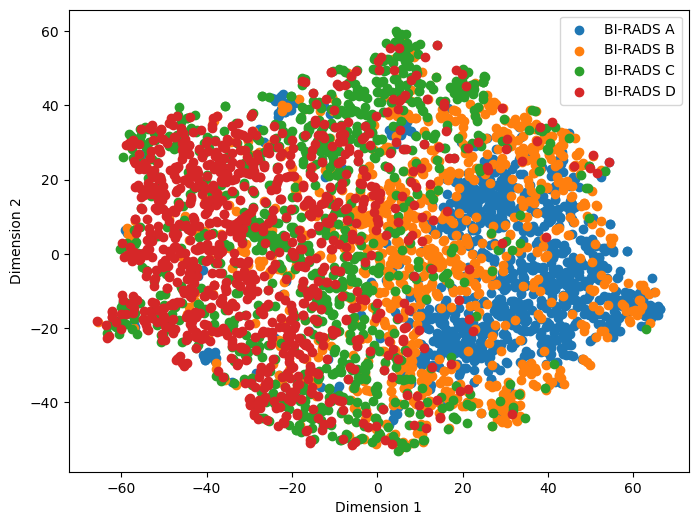

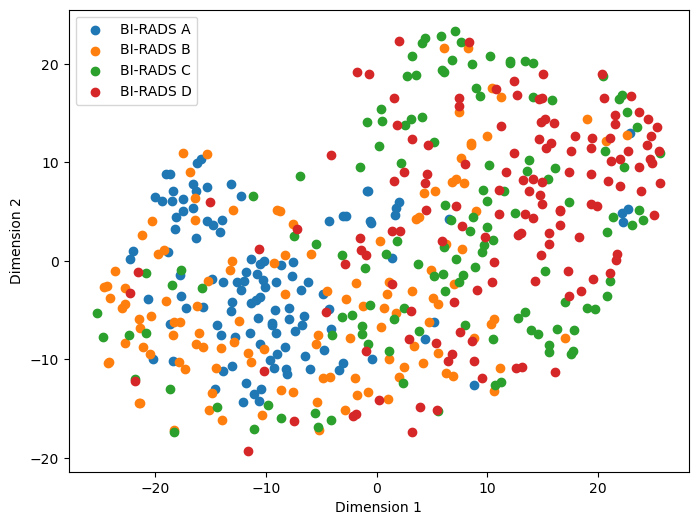

In [32]:
train_latent, train_labels = get_latent(pvae_64, dataloaders["train"], IrmaDataset.get_class_label)
latent, labels = get_latent(pvae_64, dataloaders["test"], IrmaDataset.get_class_label)

tsne = TSNE()
train_tsne_latent = tsne.fit_transform(train_latent, train_labels)
tsne_latent = tsne.fit_transform(latent)

plot_2d(train_tsne_latent, train_labels, 'tab10')
plot_2d(tsne_latent, labels, 'tab10')

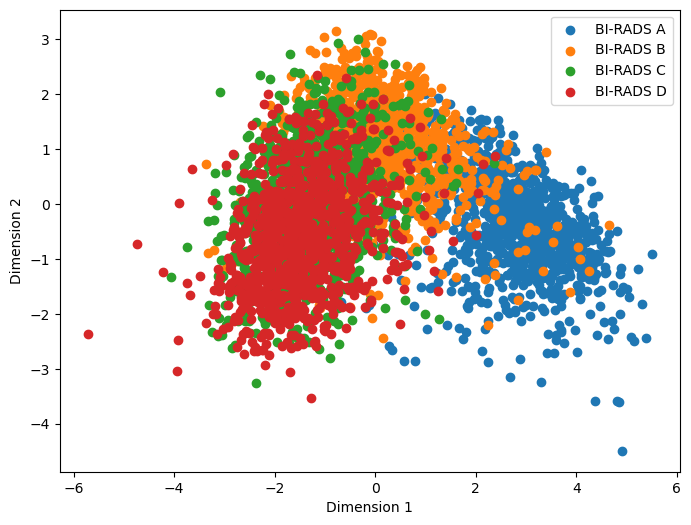

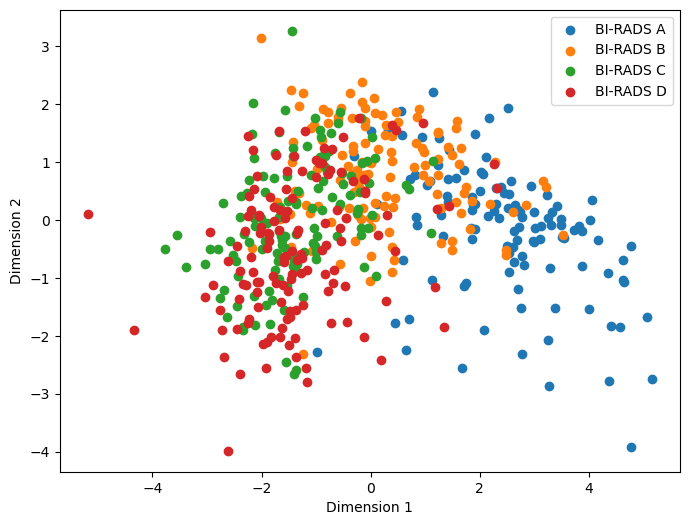

In [33]:
train_latent, train_labels = get_latent(pvae_64, dataloaders["train"], IrmaDataset.get_class_label)
latent, labels = get_latent(pvae_64, dataloaders["test"], IrmaDataset.get_class_label)

LDA = LinearDiscriminantAnalysis(n_components=2)
train_LDA_latent = LDA.fit_transform(train_latent, train_labels)
LDA_latent = LDA.transform(latent)

plot_2d(train_LDA_latent, train_labels, 'tab10')
plot_2d(LDA_latent, labels, 'tab10')

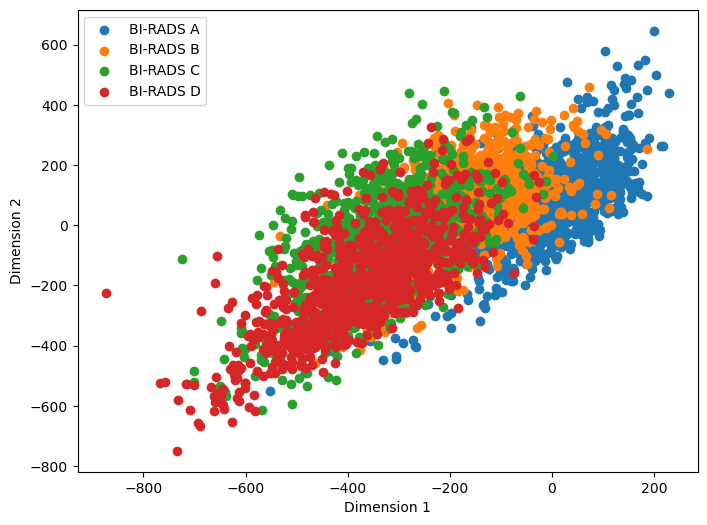

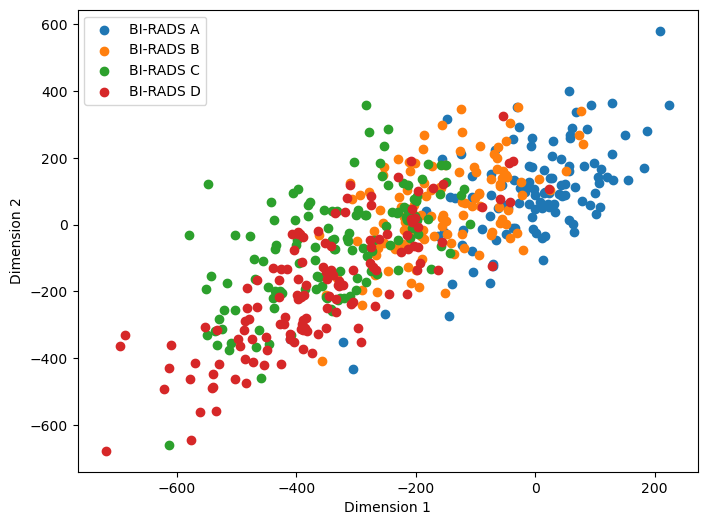

In [34]:
train_latent, train_labels = get_latent(pvae_64, dataloaders["train"], IrmaDataset.get_class_label)
latent, labels = get_latent(pvae_64, dataloaders["test"], IrmaDataset.get_class_label)

NCA = NeighborhoodComponentsAnalysis(n_components=2)
train_NCA_latent = NCA.fit_transform(train_latent, train_labels)
NCA_latent = NCA.transform(latent)

plot_2d(train_NCA_latent, train_labels, 'tab10')
plot_2d(NCA_latent, labels, 'tab10')

In [35]:
del pvae_64
torch.cuda.empty_cache()

### 128 dims

In [18]:
kwargs, state = torch.load("models/pvae_128.pt")

pvae_128 = PVAE(**kwargs)
pvae_128.load_state_dict(state)

summary(pvae_128, input_size=(32, 1, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
PVAE                                     [32, 1, 128, 128]         --
├─Encoder: 1-1                           [32, 128]                 --
│    └─Sequential: 2-1                   [32, 64, 6, 6]            --
│    │    └─Conv2d: 3-1                  [32, 192, 124, 124]       4,992
│    │    └─GELU: 3-2                    [32, 192, 124, 124]       --
│    │    └─MaxPool2d: 3-3               [32, 192, 62, 62]         --
│    │    └─Conv2d: 3-4                  [32, 128, 60, 60]         221,312
│    │    └─GELU: 3-5                    [32, 128, 60, 60]         --
│    │    └─MaxPool2d: 3-6               [32, 128, 30, 30]         --
│    │    └─Conv2d: 3-7                  [32, 96, 28, 28]          110,688
│    │    └─GELU: 3-8                    [32, 96, 28, 28]          --
│    │    └─MaxPool2d: 3-9               [32, 96, 14, 14]          --
│    │    └─Conv2d: 3-10                 [32, 64, 12, 12]          55,36

In [36]:
pvae_128 = PVAE(
    latent_dim=128,
    conv_layers=[(5, 192), (3, 128), (3, 96), (3, 64)],
    conv_pooling=[2, 2, 2, 2],
    linear_input=(64, 6, 6),
    linear_layers=[256, 128, 64],
    pred_layers=[128, 64],
    n_classes=4,
)
summary(pvae_128, input_size=(32, 1, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
PVAE                                     [32, 1, 128, 128]         --
├─Encoder: 1-1                           [32, 128]                 --
│    └─Sequential: 2-1                   [32, 64, 6, 6]            --
│    │    └─Conv2d: 3-1                  [32, 192, 124, 124]       4,992
│    │    └─GELU: 3-2                    [32, 192, 124, 124]       --
│    │    └─MaxPool2d: 3-3               [32, 192, 62, 62]         --
│    │    └─Conv2d: 3-4                  [32, 128, 60, 60]         221,312
│    │    └─GELU: 3-5                    [32, 128, 60, 60]         --
│    │    └─MaxPool2d: 3-6               [32, 128, 30, 30]         --
│    │    └─Conv2d: 3-7                  [32, 96, 28, 28]          110,688
│    │    └─GELU: 3-8                    [32, 96, 28, 28]          --
│    │    └─MaxPool2d: 3-9               [32, 96, 14, 14]          --
│    │    └─Conv2d: 3-10                 [32, 64, 12, 12]          55,36

In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(pvae_128.parameters())
pvae_128.to(device)

hist = train(pvae_128, optimizer, dataloaders['train'], dataloaders['val'], 32, pred_kl_reconstruction_loss)
# hist = train(ae, optimizer, dataloader, dataloader, 20)

[epoch: 1] train_loss: 29.1687 train_rec_loss: 27.7695 train_kl_loss: 0.0214 train_pred_loss: 1.3778 train_accuracy: 0.2763 - val_loss: 21.7694 val_rec_loss: 20.4321 val_kl_loss: 0.0298 val_pred_loss: 1.3076 val_accuracy: 0.3897
[epoch: 2] train_loss: 14.9657 train_rec_loss: 13.6582 train_kl_loss: 0.0427 train_pred_loss: 1.2648 train_accuracy: 0.4393 - val_loss: 10.3719 val_rec_loss: 9.0309 val_kl_loss: 0.0631 val_pred_loss: 1.2779 val_accuracy: 0.4414
[epoch: 3] train_loss: 10.1691 train_rec_loss: 8.8804 train_kl_loss: 0.0564 train_pred_loss: 1.2323 train_accuracy: 0.4866 - val_loss: 9.3856 val_rec_loss: 8.1082 val_kl_loss: 0.0637 val_pred_loss: 1.2137 val_accuracy: 0.4871
[epoch: 4] train_loss: 9.4656 train_rec_loss: 8.1967 train_kl_loss: 0.0602 train_pred_loss: 1.2087 train_accuracy: 0.5204 - val_loss: 9.1591 val_rec_loss: 7.9059 val_kl_loss: 0.0656 val_pred_loss: 1.1875 val_accuracy: 0.5348
[epoch: 5] train_loss: 9.1129 train_rec_loss: 7.8588 train_kl_loss: 0.0632 train_pred_loss: 

In [38]:
torch.save((pvae_128.kwargs ,pvae_128.state_dict()), "models/pvae_128.pt")

test_loss: 5.3885 test_rec_loss: 4.2768 test_kl_loss: 0.0829 test_pred_loss: 1.0288 test_accuracy: 0.6978


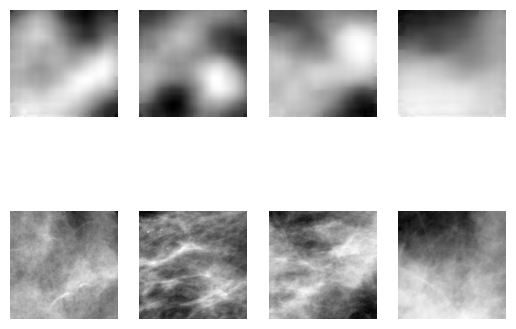

In [19]:
test_metrics = validate(pvae_128, dataloaders['test'], pred_kl_reconstruction_loss)

print(get_metrics_str(test_metrics, 'test_'))

plot_reconstructions(pvae_128, dataloaders['test'])

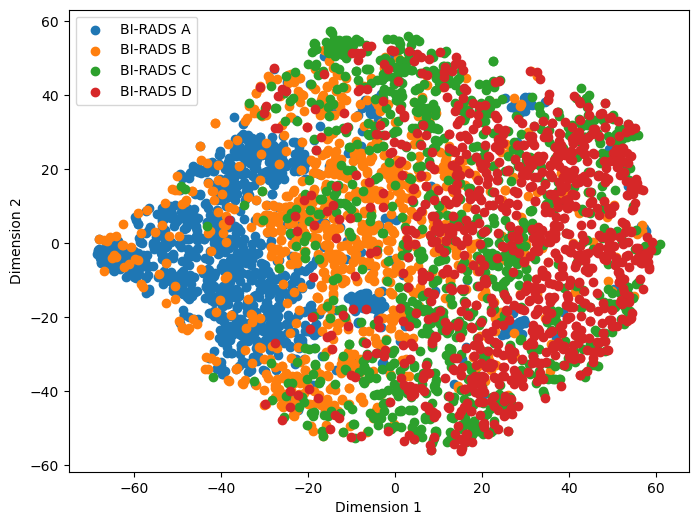

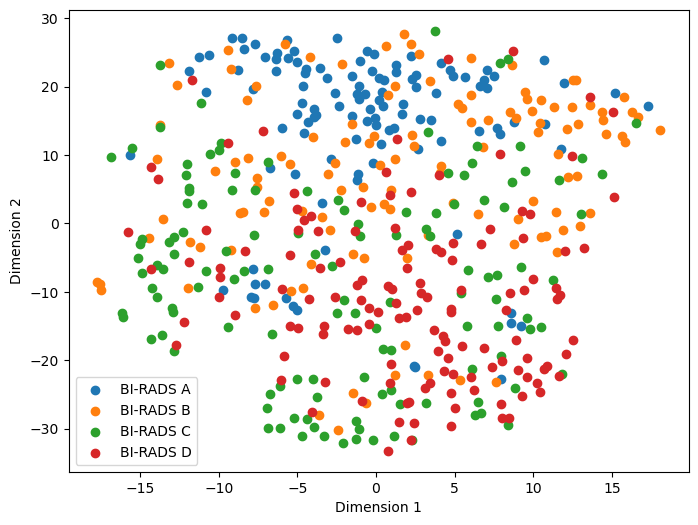

In [40]:
train_latent, train_labels = get_latent(pvae_128, dataloaders["train"], IrmaDataset.get_class_label)
latent, labels = get_latent(pvae_128, dataloaders["test"], IrmaDataset.get_class_label)

tsne = TSNE()
train_tsne_latent = tsne.fit_transform(train_latent, train_labels)
tsne_latent = tsne.fit_transform(latent)

plot_2d(train_tsne_latent, train_labels, 'tab10')
plot_2d(tsne_latent, labels, 'tab10')

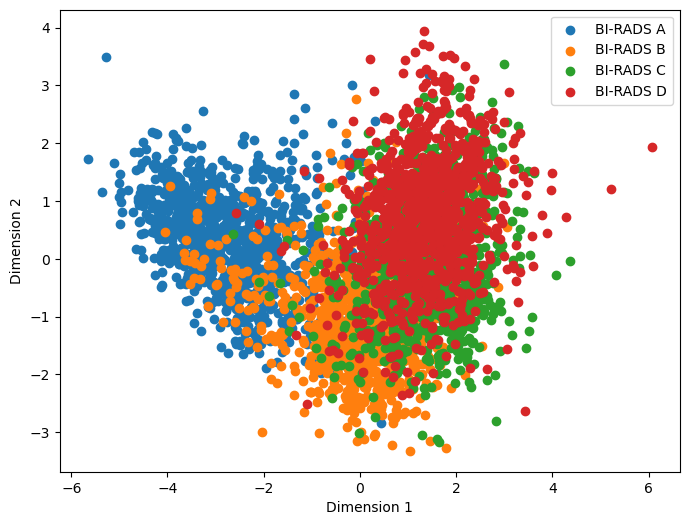

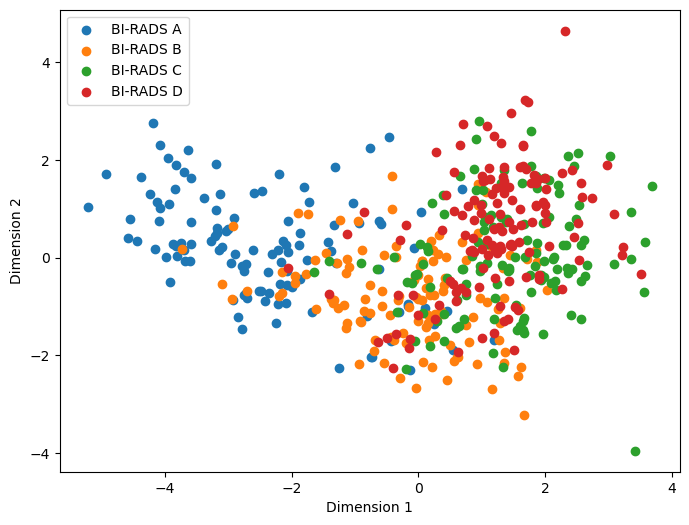

In [41]:
train_latent, train_labels = get_latent(pvae_128, dataloaders["train"], IrmaDataset.get_class_label)
latent, labels = get_latent(pvae_128, dataloaders["test"], IrmaDataset.get_class_label)

LDA = LinearDiscriminantAnalysis(n_components=2)
train_LDA_latent = LDA.fit_transform(train_latent, train_labels)
LDA_latent = LDA.transform(latent)

plot_2d(train_LDA_latent, train_labels, 'tab10')
plot_2d(LDA_latent, labels, 'tab10')

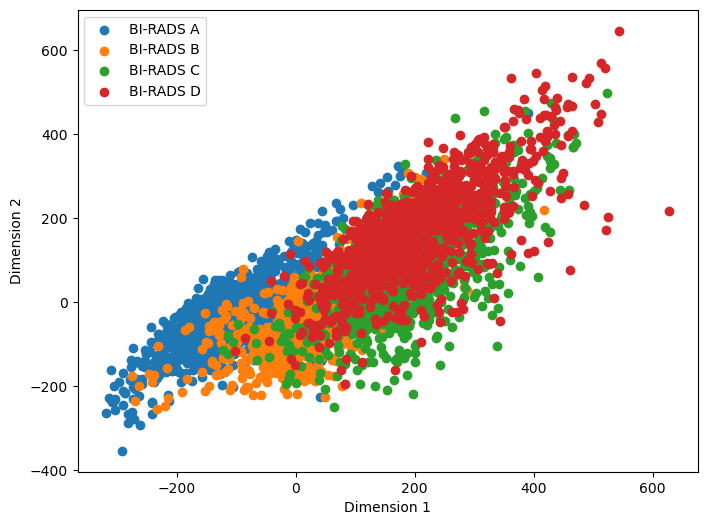

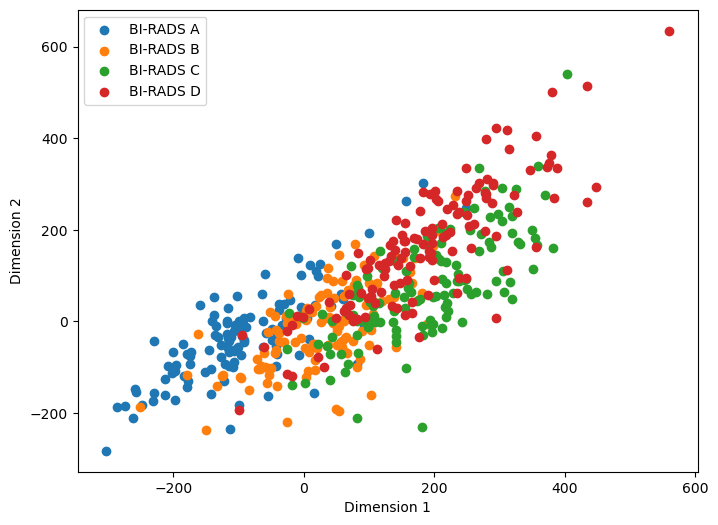

In [42]:
train_latent, train_labels = get_latent(pvae_128, dataloaders["train"], IrmaDataset.get_class_label)
latent, labels = get_latent(pvae_128, dataloaders["test"], IrmaDataset.get_class_label)

NCA = NeighborhoodComponentsAnalysis(n_components=2)
train_NCA_latent = NCA.fit_transform(train_latent, train_labels)
NCA_latent = NCA.transform(latent)

plot_2d(train_NCA_latent, train_labels, 'tab10')
plot_2d(NCA_latent, labels, 'tab10')